In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

from gym_minigrid_navigation.utils import show_video
from navigation_policy import gen_env, get_agent, run_episode, run_episodes

from rewards import get_reward_function
from utils import init_logger, switch_reproducibility_on, display_stats

from expected_steps import ExpectedStepsAmountLeaner
from rewards import ExpectedStepsAmountReward

import logging
logger = logging.getLogger(__name__)

init_logger('__main__')

init_logger('dqn')
init_logger('expected_steps')
init_logger('navigation_policy')
init_logger('gym_minigrid_navigation.environments')

### config 

In [4]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../conf/minigrid_dqn_draft.hocon')
config['env']['video_path'] = '../outputs/video/'

switch_reproducibility_on(config['seed'])

### agent and steps amount model

In [5]:
agent = get_agent(config)

2021-02-18 10:08:06,709 INFO    dqn                    : Running on device: cuda:0


### steps amount model trainings 

In [6]:
expected_steps_learner = ExpectedStepsAmountLeaner(config['expected_steps_params'])

In [7]:
config['env']['goal_type'] = 'random'

In [8]:
env = gen_env(config['env'], reward_function=lambda *args: 0)

In [9]:
expected_steps_learner.config['update_step'] = 10_000_000

scores, steps = run_episodes(
    env=env,
    agent=agent,
    steps_learner=expected_steps_learner,
    n_episodes=config['expected_steps_params.warm_up'],
    agent_train_mode=False,
    verbose=config['training.verbose'],
    max_steps=config['expected_steps_params.warm_up_max_steps']
)

../navigation_policy.py:73: RuntimeWarning: Mean of empty slice.
  avg_loss = np.array(losses).mean()
/mnt/nikita/rllr/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
2021-02-18 10:08:22,381 INFO    navigation_policy      : Episode: 100. scores: 0.00, steps: 34.26, L1loss: nan
2021-02-18 10:08:34,415 INFO    navigation_policy      : Episode: 200. scores: 0.00, steps: 35.63, L1loss: nan
2021-02-18 10:08:46,141 INFO    navigation_policy      : Episode: 300. scores: 0.00, steps: 35.93, L1loss: nan
2021-02-18 10:08:57,188 INFO    navigation_policy      : Episode: 400. scores: 0.00, steps: 34.78, L1loss: nan
2021-02-18 10:09:08,516 INFO    navigation_policy      : Episode: 500. scores: 0.00, steps: 36.24, L1loss: nan
2021-02-18 10:09:20,001 INFO    navigation_policy      : Episode: 600. scores: 0.00, steps: 36.45, L1loss: nan
2021-02-18 10:09:30,789 INFO    navigation_policy      :

KeyboardInterrupt: 

In [ ]:
agent.eps

### agent training 

In [ ]:
reward_function = ExpectedStepsAmountReward(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=reward_function)

In [ ]:
expected_steps_learner.config['update_step'] = 10_000_000

scores, steps = run_episodes(
    env=env,
    agent=agent,
    steps_learner=expected_steps_learner,
    n_episodes=config['training.n_episodes'],
    verbose=config['training.verbose']
)

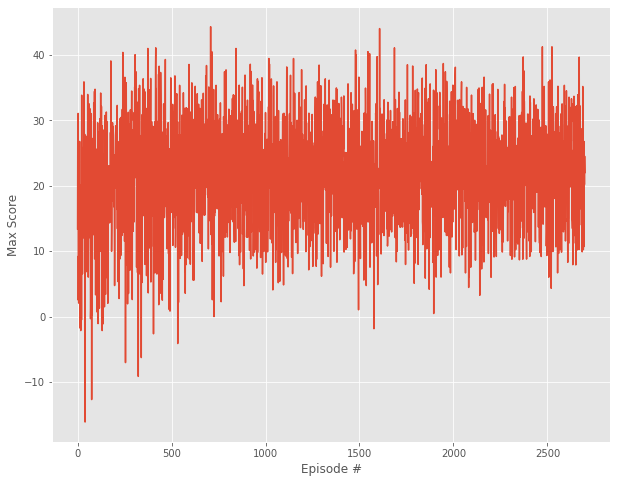

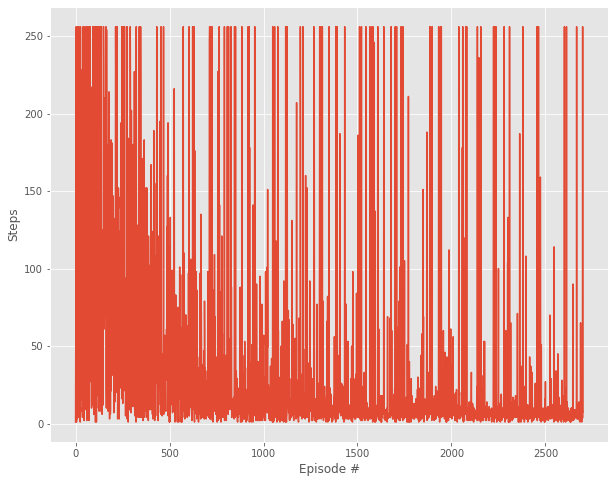

In [14]:
display_stats(scores, steps)

In [15]:
env = gen_env(config['env'], reward_function, verbose=True)
print(run_episode(env, agent, train_mode=True))

show_video(config['env.video_path'])

TypeError: run_episode() got an unexpected keyword argument 'train_mode'

In [ ]:
None / 3

In [ ]:
import numpy as np
np.nan / 3

In [ ]:
a = 0
a += np.nan
a == np.nan

In [ ]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../conf/minigrid_dqn_navigation_draft.hocon')
config['env']['video_path'] = '../outputs/video/'

switch_reproducibility_on(config['seed'])

### trainings 

In [ ]:
# reward_function = get_reward_function(config)
reward_function = get_reward_function({'training.reward': 'explicit_pos_reward'})

agent = get_agent(config)
env = gen_env(config['env'], reward_function)
scores, steps = run_episodes(env, agent, n_episodes=config['training.n_episodes'], verbose=config['training.verbose'])

display_stats(scores, steps)

### visualisation 

In [ ]:
# env = gen_env(config['env'], reward_function, verbose=True)
# print(run_episode(env, agent, train_mode=False))

# show_video(config['env.video_path'])

In [ ]:
import random
import torch
import numpy as np

from fast_tensor_data_loader import FastTensorDataLoader
from expected_steps import ExpectedStepsAmountModel
from rewards import ExpectedStepsAmount

In [ ]:
grid_size = config['env.grid_size'] * config['env'].get('tile_size', 1)

In [ ]:
expected_steps_learner = ExpectedStepsAmountModel(grid_size, config['training.reward_params'])
agent = get_agent(config)

In [ ]:
env = gen_env(config['env'], reward_function=lambda *args: 0)
env.env.env.max_steps = 40  # TOBD: config
expected_steps_learner.model.fc[-1].bias.data.fill_(20.)

expected_steps_learner.reset_buffer()
expected_steps_learner.collect_episodes(env, agent)
expected_steps_learner.learn(verbose=True)

arr = np.array([x for _, _, x in expected_steps_learner.buffer])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')    

In [ ]:
# agent = get_agent(config)

In [ ]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=expected_reward_function)
# env.env.env.max_steps = 50  # TOBD: config

# agent.reset_buffer()
scores, steps = run_episodes(env, agent, n_episodes=3000, verbose=300)

In [ ]:
env = gen_env(config['env'], expected_reward_function, verbose=True)
print(run_episode(env, agent, train_mode=True))

show_video(config['env.video_path'])

In [ ]:
env = gen_env(config['env'], reward_function=lambda *args: 0)
env.env.env.max_steps = 40  # TOBD: config
expected_steps_learner.model.fc[-1].bias.data.fill_(20.)

expected_steps_learner.reset_buffer()
expected_steps_learner.collect_episodes(env, agent)
expected_steps_learner.learn(verbose=True)

arr = np.array([x for _, _, x in expected_steps_learner.buffer])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')  

In [ ]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=expected_reward_function)
# env.env.env.max_steps = 50  # TOBD: config

agent.reset_buffer()
scores, steps = run_episodes(env, agent, n_episodes=3000, verbose=300)

In [ ]:
agent.eps

In [ ]:
config = ConfigFactory.parse_file('../conf/minigrid_dqn_draft.hocon')
config['env']

In [ ]:
stop

In [ ]:
import torch

def metric(model, buffer, device=torch.device('cuda')):
    def _vstack(arr):
        arr = np.vstack([np.expand_dims(x, axis=0) for x in arr])
        return torch.from_numpy(arr).float()

    states, goal_states, y = map(_vstack, zip(*buffer))
    y = y.squeeze()
    y = torch.clamp(y, max=20)  # !!! hot fix
    model.eval()
    
    loss_fn = torch.nn.L1Loss()
    train_loader = FastTensorDataLoader(states, goal_states, y, batch_size=1000)

    loss_sum = 0
    for batch_state, batch_goal_state, batch_y in train_loader:
        with torch.no_grad():
            output = model(batch_state.to(device), batch_goal_state.to(device))
            loss = loss_fn(output, batch_y.to(device))
        loss_sum += loss.cpu().numpy().item()
    return loss_sum / len(train_loader)

In [ ]:
import random
import torch
import numpy as np

from navigation_policy import *
from expected_steps import ExpectedStepsAmountLearner
from rewards import ExpectedStepsAmount
from fast_tensor_data_loader import FastTensorDataLoader

In [ ]:
config = ConfigFactory.parse_file('../conf/minigrid_dqn_navigation_draft.hocon')
config['env']['video_path'] = '../outputs/video/'

grid_size = config['env.grid_size'] * config['env'].get('tile_size', 1)

In [ ]:
expected_steps_learner = ExpectedStepsAmountLearner(grid_size, config['training.reward_params'])

env = gen_env(config['env'], reward_function=lambda *args: 0)
env.env.env.max_steps = 20  # TOBD: config
# expected_steps_learner.model.fc[-1].bias.data.fill_(10.)
    
expected_steps_learner.collect_episodes(env, agent)
valid_buffer = expected_steps_learner.buffer

print(len(valid_buffer))

In [ ]:
for i in range(20):
    expected_steps_learner.reset_buffer()
    expected_steps_learner.collect_episodes(env, agent)

    expected_steps_learner.learn()

    metric_valid = metric(expected_steps_learner.model, valid_buffer)
    metric_train = metric(expected_steps_learner.model, expected_steps_learner.buffer)
    mean_steps = sum([x for _, _, x in expected_steps_learner.buffer]) / len(expected_steps_learner.buffer)
    print(f"epochs {i}: metric_train = {metric_train :.2f}, metric_valid = {metric_valid :.2f}, mean_steps: {mean_steps}")

In [ ]:
config['training']['n_episodes'] = 3000

expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)
env = gen_env(config['env'], reward_function=expected_reward_function)

new_agent = get_agent(config)
scores, steps = run_episodes(env, new_agent, n_episodes=config['training.n_episodes'], verbose=config['training.verbose'])

display_stats(scores, steps)

In [ ]:
#

In [ ]:
env = gen_env(config['env'], reward_function, verbose=True)
print(run_episode(env, new_agent, train_mode=False))

show_video(config['env.video_path'])

In [ ]:
arr = np.array(steps[-300:])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')

In [ ]:
config['training.reward_params']['buffer_size'] = 5_000

In [ ]:
expected_steps_learner = ExpectedStepsAmountLearner(grid_size, config['training.reward_params'])
agent = get_agent(config)

In [ ]:
env = gen_env(config['env'], reward_function=lambda *args: 0, verbose=False)
env.env.env.max_steps = 4  # TOBD: config
expected_steps_learner.model.fc[-1].bias.data.fill_(2.)

expected_steps_learner.reset_buffer()
expected_steps_learner.collect_episodes(env, agent)
expected_steps_learner.learn(verbose=True)

arr = np.array([x for _, _, x in expected_steps_learner.buffer])
logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')

expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model, 2.5)

In [ ]:
env = gen_env(config['env'], reward_function=lambda *args: 0, verbose=True)
state = env.reset()
goal_state = env.env.env.goal_state

import numpy as np

start_pos = (5, 3)
ens_pos = (2, 3)
state_ = np.copy(state)

In [ ]:
next_state = np.copy(state_)
state = np.copy(state_)
expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

In [ ]:
state = np.copy(next_state)
next_state[4, 2] = next_state[5, 2]
next_state[5, 2] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

In [ ]:
state = np.copy(next_state)
next_state[3, 2] = next_state[4, 2]
next_state[4, 2] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

In [ ]:
state = np.copy(next_state)
next_state[3, 3] = next_state[3, 2]
next_state[3, 2] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

In [ ]:
state = np.copy(next_state)
next_state[3, 4] = next_state[3, 3]
next_state[3, 3] = [1, 0, 0]

expected_reward_function(state, next_state, goal_state), to_coords(state), to_coords(next_state), to_coords(goal_state)

In [ ]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model, 2.5)
env = gen_env(config['env'], reward_function=expected_reward_function)
# env.env.env.max_steps = 50  # TOBD: config

agent = get_agent(config)
agent.reset_buffer()

for x in range(40):
    scores, steps = run_episodes(env, agent, n_episodes=25, verbose=25)
    arr = np.array(steps)
    logger.info(f'{np.quantile(arr, np.arange(0, 1, 0.1))}')

In [ ]:
def to_coords(state):
    obj_pos = (state == 10).nonzero()
    return obj_pos[0].item(), obj_pos[1].item()

In [ ]:
model = expected_reward_function.model
dist = model(expected_reward_function._to_torch(state), expected_reward_function._to_torch(goal_state))

to_coords(state), to_coords(goal_state), dist

In [ ]:
expected_reward_function = ExpectedStepsAmount(expected_steps_learner.model)

In [ ]:
state[:,:,0], next_state[:,:,0]

In [ ]:
state.shape

In [ ]:
next_state = np.copy(state)

next_state[1, 3] = 0
next_state[5, 3] = np.array([10, 0, 0])
expected_reward_function(state, next_state, goal_state)

In [ ]:
next_state = np.copy(state)
expected_reward_function(state, next_state, goal_state)

In [ ]:
goal_state[12:16, 12:16, 0]

In [ ]:
[:, :, 0]

In [ ]:
agent.qnetwork_target.master

In [ ]:
model = agent.qnetwork_target.master
model.output_size

In [ ]:
model(states).shape

In [ ]:
np.linalg.norm(state - goal_state) / 255

In [ ]:
state / np.linalg.norm(state)

In [ ]:
np.linalg.norm(state)

In [ ]:
state / 